In [1]:
import h5py
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import fcluster, dendrogram, linkage
from scipy.spatial.distance import pdist

/nfs_home/nallapar/miniconda3/envs/riboclette/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
filename = '/net/lts2gdk0/mnt/scratch/lts2/nallapar/rb-prof/data/Jan_2024/Lina/full_Test_LIXG_RiboGL.h5'

distance_thresh = 20 # for the global attribution average plot
attr_segment_length = 20 # num codons on each side

# load h5
int_ds = h5py.File(filename, 'r')
int_ds.keys()

<KeysViewHDF5 ['edge_attr', 'edge_index', 'node_attr', 'transcript', 'x_input', 'y_pred', 'y_true']>

In [3]:
# make a dataframe
distance_from_A_site = []
attribution_value = []

len_samples = len(int_ds['node_attr'])

for i in tqdm(range(len_samples)):
    node_attr_sample = int_ds['node_attr'][i]
    # take absolute value
    node_attr_sample = np.abs(node_attr_sample)
    # num codons is square root of length of node_attr_sample
    num_codons = int(len(node_attr_sample)**0.5)
    # convert to 2D array of shape (num_codons, num_codons)
    node_attr_sample = node_attr_sample.reshape(num_codons, num_codons)
    # iterate over each row
    for j in range(num_codons):
        # iterate over each column
        # normalize this row by dividing by the max value
        node_attr_sample[j] = node_attr_sample[j] / np.max(node_attr_sample[j])
        for k in range(num_codons):
            # add to the dataframe
            if abs(j-k) <= distance_thresh:
                distance_from_A_site.append(j-k)
                attribution_value.append(node_attr_sample[j][k])

print(len(distance_from_A_site))
# make a dict
data = {'Distance from A site': distance_from_A_site, 'Attribution Value': attribution_value}

# make a dataframe
df_distance_attr = pd.DataFrame(data)

100%|██████████| 1284/1284 [01:06<00:00, 19.33it/s]


22640521


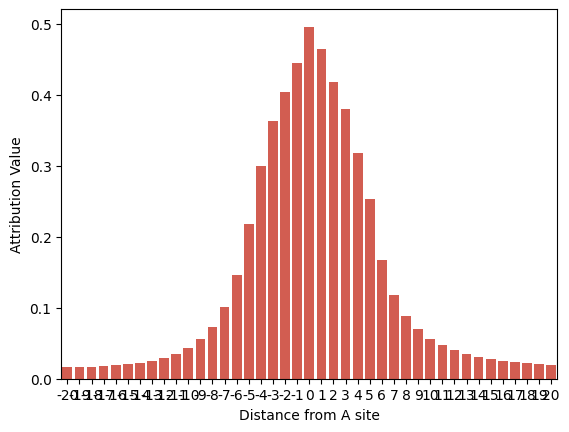

In [4]:
# get mean attribution value for each distance
df_distance_attr = df_distance_attr.groupby('Distance from A site').mean().reset_index()

# make a bar plot for ds_attr_dist from distance -10 to +10
sns.barplot(x='Distance from A site', y='Attribution Value', data=df_distance_attr, color='#e74c3c')
plt.show()

In [5]:
# make a list of lists with attr_segments centered around the A site
attr_segment_lists = []

for i in tqdm(range(len_samples)):
    node_attr_sample = int_ds['node_attr'][i]
    # take absolute value
    node_attr_sample = np.abs(node_attr_sample)
    # num codons is square root of length of node_attr_sample
    num_codons = int(len(node_attr_sample)**0.5)
    # convert to 2D array of shape (num_codons, num_codons)
    node_attr_sample = node_attr_sample.reshape(num_codons, num_codons)
    # iterate over each row
    for j in range(attr_segment_length, num_codons-attr_segment_length-1):
        # iterate over each column
        # normalize this row by dividing by the max value
        node_attr_sample[j] = node_attr_sample[j] / np.max(node_attr_sample[j])
        # add to the segment list 
        attr_segment = node_attr_sample[j][j-attr_segment_length:j+attr_segment_length+1]

        assert len(attr_segment) == (2*attr_segment_length + 1)

        attr_sample_dict = {'attr_segment': attr_segment, 'sample_id': i, 'codon_id': j, 'transcript': int_ds['transcript'][i]}

        attr_segment_lists.append(attr_sample_dict)

print("Number of Attr Segments: ", len(attr_segment_lists))
        

100%|██████████| 1284/1284 [02:27<00:00,  8.73it/s]

Number of Attr Segments:  512717


In [6]:
np.random.shuffle(attr_segment_lists)
attr_segment_lists = np.array(attr_segment_lists[:10000])

In [ ]:
# construct a dendrogram of the segments using hclust 
only_segments = []
for i in range(len(attr_segment_lists)):
    only_segments.append(attr_segment_lists[i]['attr_segment'])
distances_attr = pdist(only_segments, metric='euclidean')
print("Made distance wise matrix for the segments")
Z = linkage(distances_attr, method='complete')

# plot the dendrogram for this and color them according to the clusters that are generated
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(Z, leaf_rotation=90., leaf_font_size=8.)
plt.show()


In [ ]:
# get clusters from Z
clusters = fcluster(Z, t=2.5, criterion='distance')

print("Number of Clusters: ", len(set(clusters)))

np.unique(clusters,
          return_counts=True)
# sort in descending order of cluster size
cluster_size = np.unique(clusters, return_counts=True)
print(np.flip(np.argsort(cluster_size[1])))

In [ ]:
# make plots for each of the clusters, with their averaged segment
for i in np.flip(np.argsort(cluster_size[1])):
    cluster_indices = np.where(clusters == i+1)[0]
    if len(cluster_indices) < 50:
        continue
    print("Cluster: ", i)
    print("Number of segments: ", len(cluster_indices))
    cluster_segments = attr_segment_lists[cluster_indices]
    cluster_segments = np.mean(cluster_segments, axis=0)
    sns.barplot(x=range(-10, 10), y=cluster_segments, color='#e74c3c')
    plt.show()
    print("----------------------------------------------------")

Made distance wise matrix for the segments


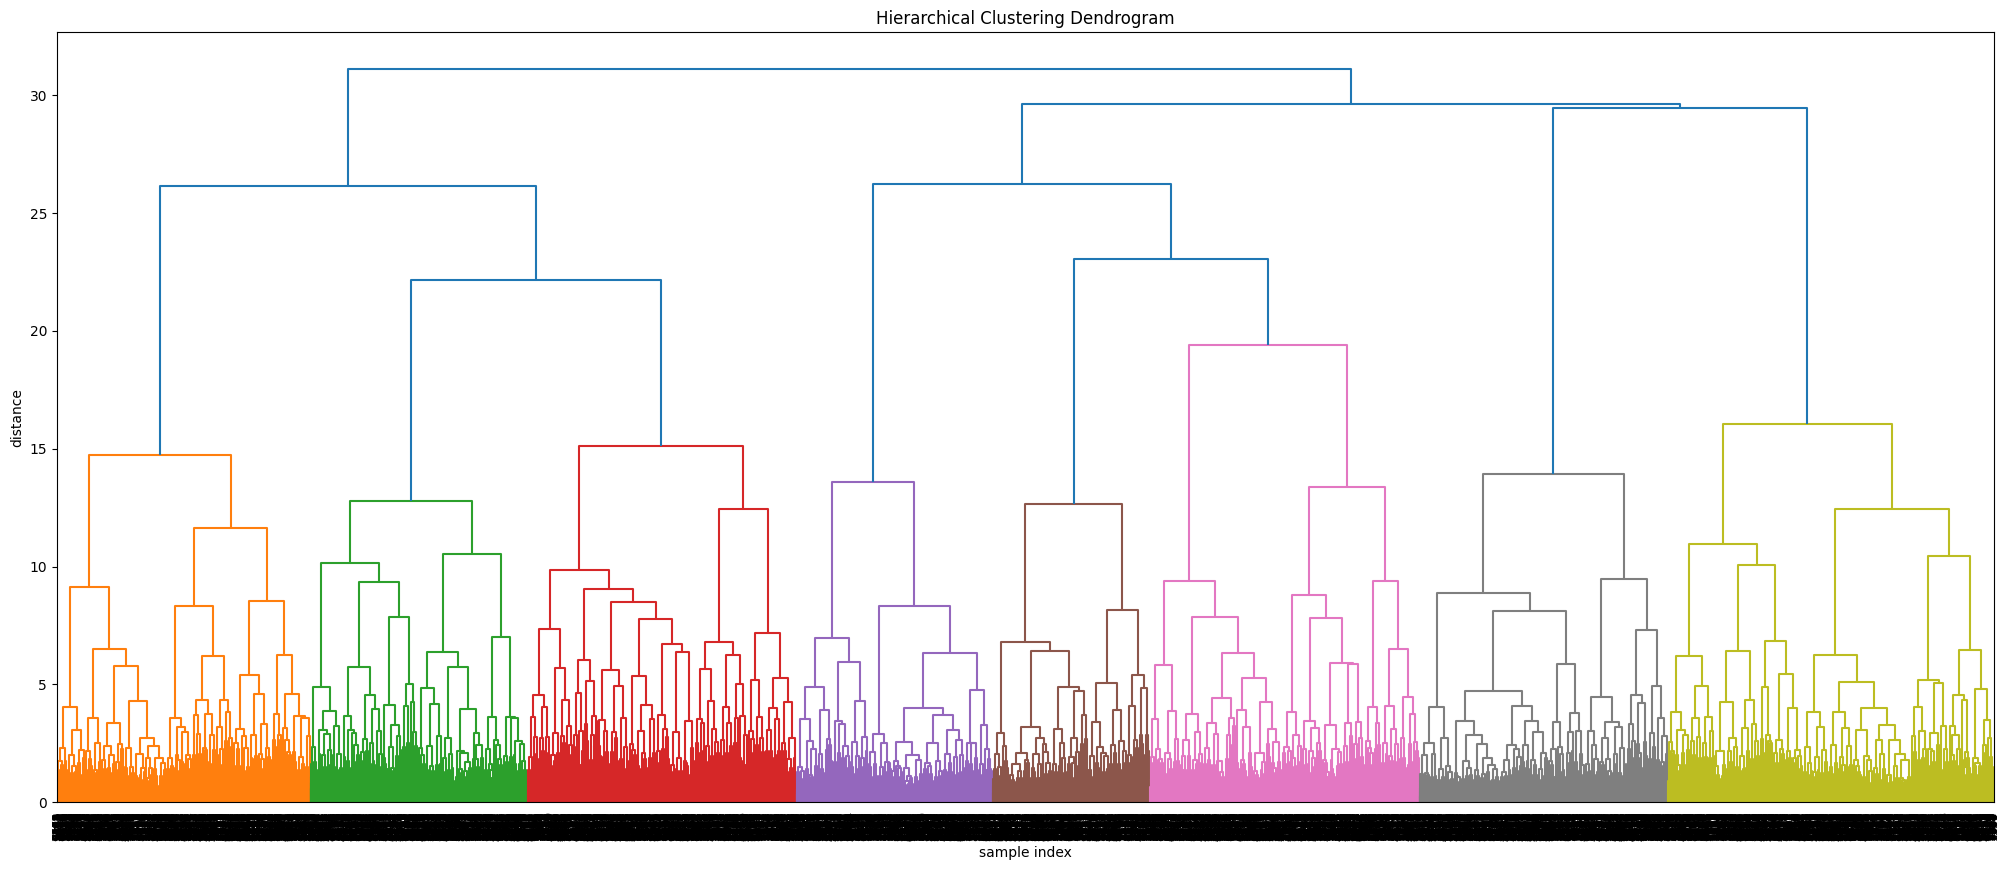

In [7]:
# construct a dendrogram of the segments using hclust 
only_segments = []
for i in range(len(attr_segment_lists)):
    only_segments.append(attr_segment_lists[i]['attr_segment'])
distances_attr = pdist(only_segments, metric='euclidean')
print("Made distance wise matrix for the segments")
Z = linkage(distances_attr, method='ward')

# plot the dendrogram for this and color them according to the clusters that are generated
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(Z, leaf_rotation=90., leaf_font_size=8.)
plt.show()

In [9]:
# get clusters from Z
clusters = fcluster(Z, t=12, criterion='distance')

print("Number of Clusters: ", len(set(clusters)))

np.unique(clusters,
          return_counts=True)
# sort in descending order of cluster size
cluster_size = np.unique(clusters, return_counts=True)
# print(np.flip(np.argsort(cluster_size[1])))

Number of Clusters:  19


Cluster:  4
Number of segments:  859
41


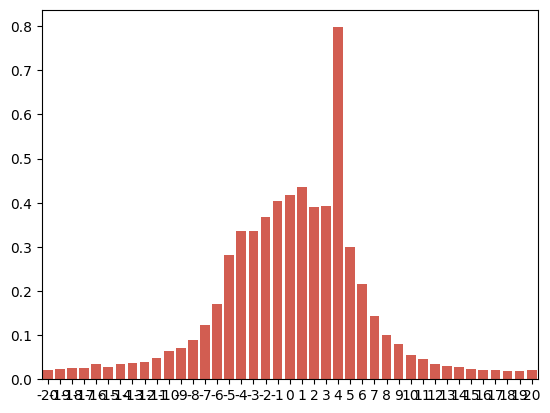

----------------------------------------------------
Cluster:  14
Number of segments:  854
41


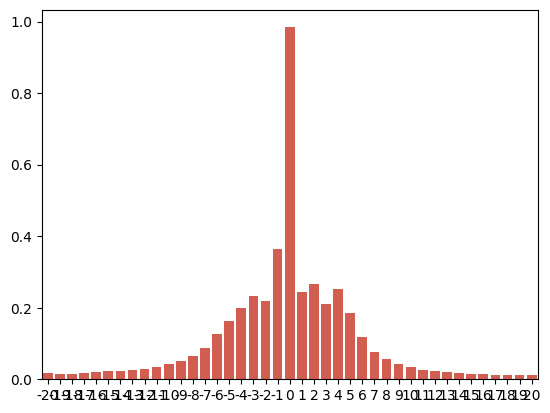

----------------------------------------------------
Cluster:  1
Number of segments:  743
41


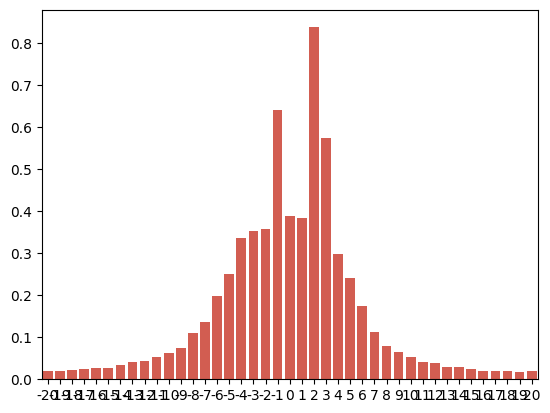

----------------------------------------------------
Cluster:  16
Number of segments:  699
41


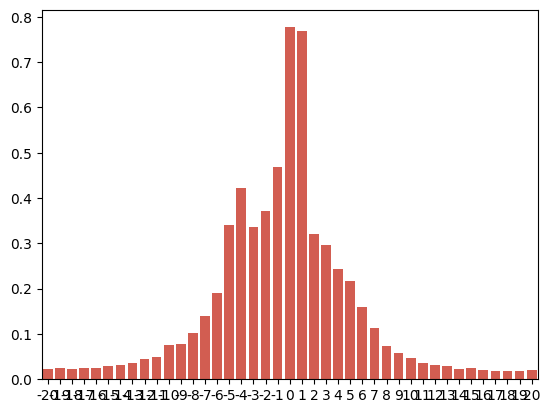

----------------------------------------------------
Cluster:  11
Number of segments:  679
41


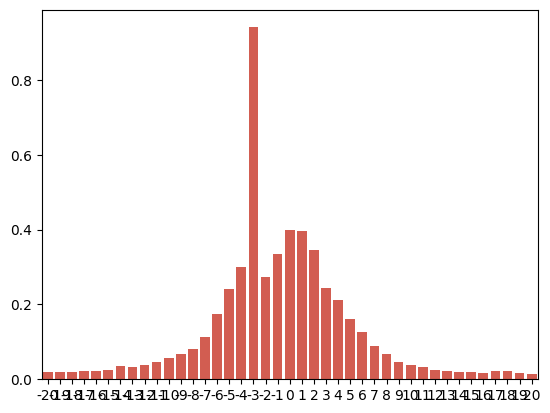

----------------------------------------------------
Cluster:  8
Number of segments:  640
41


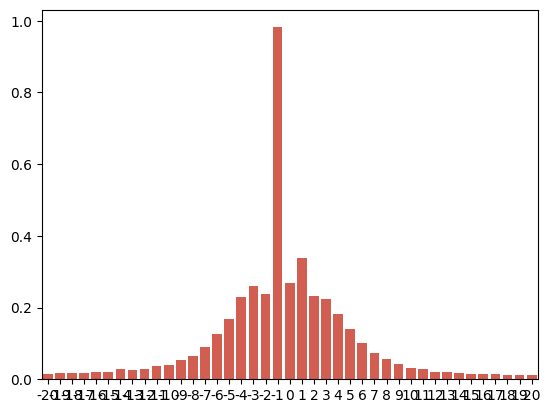

----------------------------------------------------
Cluster:  3
Number of segments:  568
41


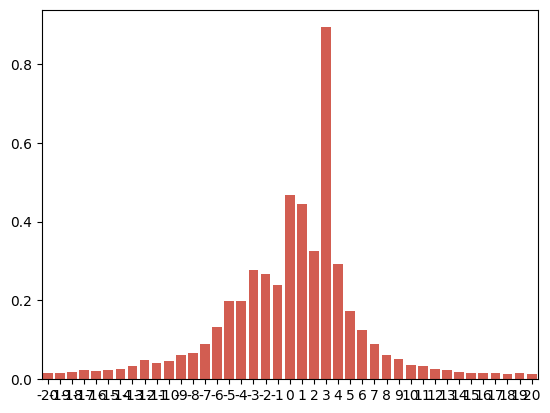

----------------------------------------------------
Cluster:  0
Number of segments:  566
41


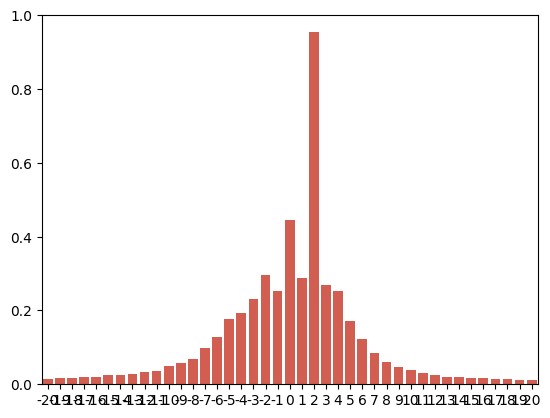

----------------------------------------------------
Cluster:  17
Number of segments:  557
41


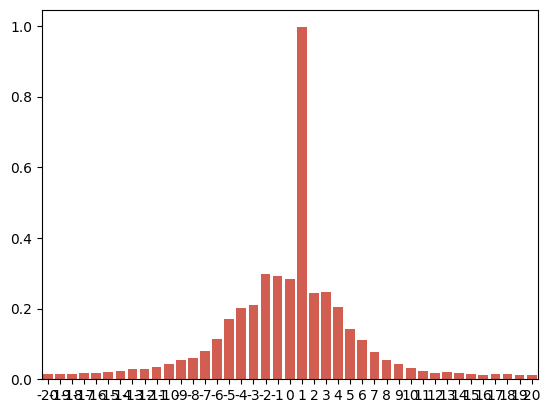

----------------------------------------------------
Cluster:  2
Number of segments:  555
41


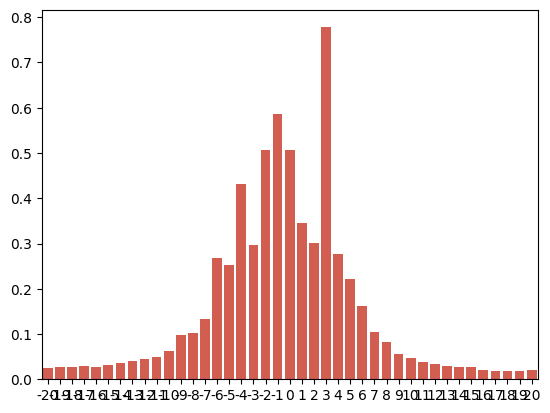

----------------------------------------------------
Cluster:  9
Number of segments:  491
41


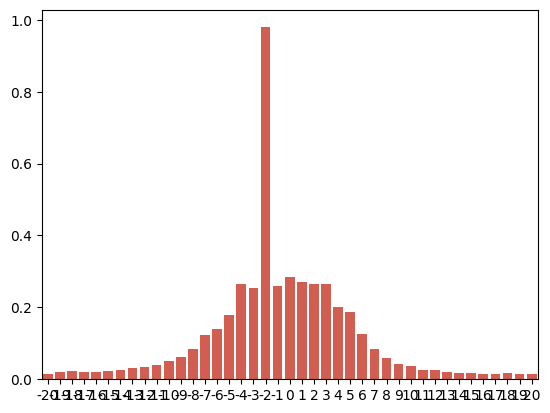

----------------------------------------------------
Cluster:  15
Number of segments:  429
41


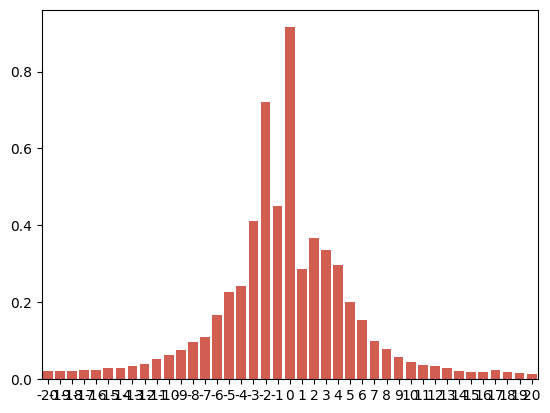

----------------------------------------------------
Cluster:  18
Number of segments:  428
41


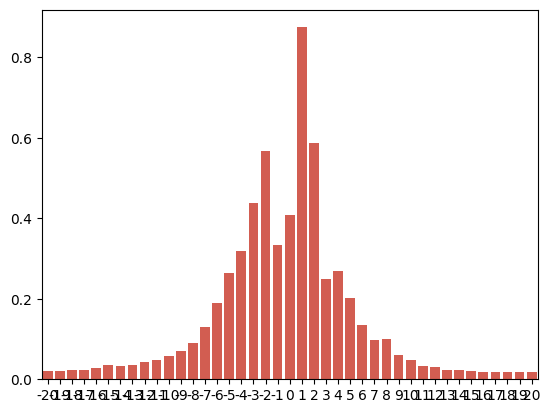

----------------------------------------------------
Cluster:  12
Number of segments:  427
41


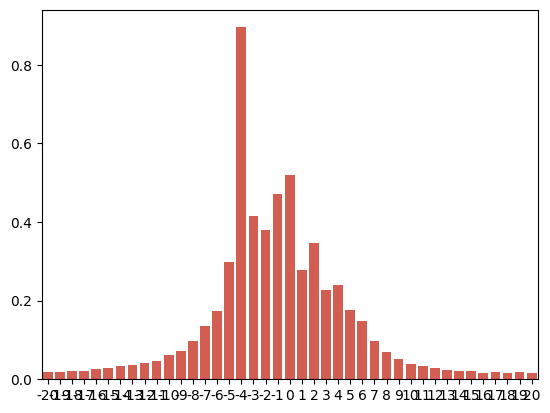

----------------------------------------------------
Cluster:  7
Number of segments:  373
41


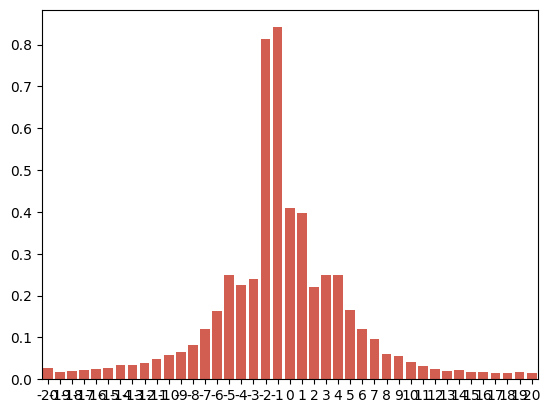

----------------------------------------------------
Cluster:  10
Number of segments:  321
41


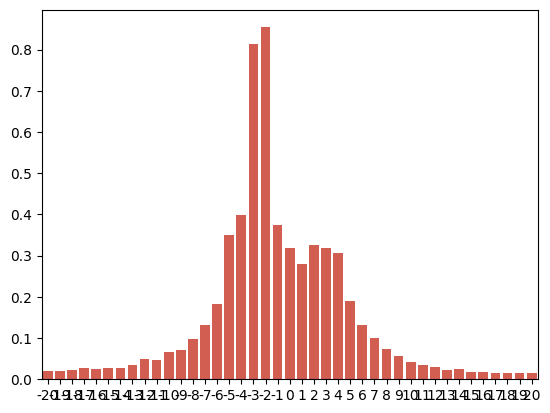

----------------------------------------------------
Cluster:  13
Number of segments:  284
41


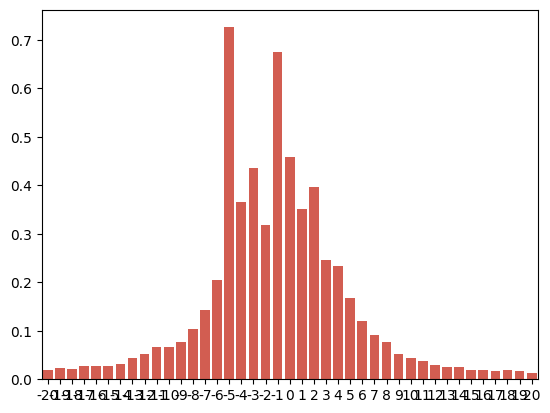

----------------------------------------------------
Cluster:  5
Number of segments:  275
41


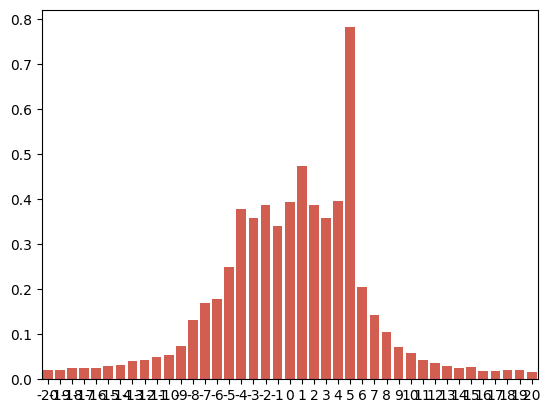

----------------------------------------------------
Cluster:  6
Number of segments:  252
41


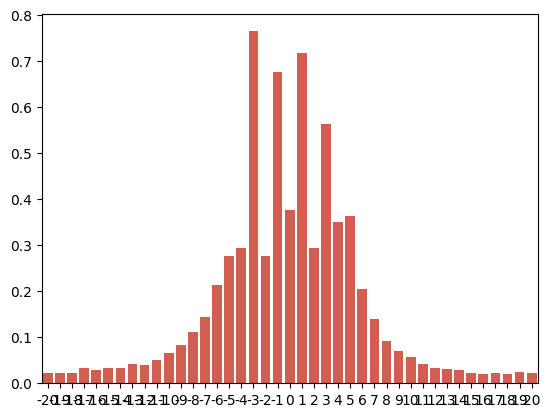

----------------------------------------------------


In [16]:
# make plots for each of the clusters, with their averaged segment
for i in np.flip(np.argsort(cluster_size[1])):
    cluster_indices = np.where(clusters == i+1)[0]
    # if len(cluster_indices) < 50:
    #     continue
    print("Cluster: ", i)
    print("Number of segments: ", len(cluster_indices))
    # get all the cluster segments
    cluster_segments = []
    for j in cluster_indices:
        cluster_segments.append(only_segments[j])
    cluster_segments = np.mean(cluster_segments, axis=0)
    sns.barplot(x=range(-attr_segment_length, attr_segment_length+1), y=cluster_segments, color='#e74c3c')
    plt.show()
    print("----------------------------------------------------")